In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from SplunkResearch.resources.section_logtypes import section_logtypes
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression

In [2]:
section_logtypes = {'Detect New Local Admin Account': [('wineventlog:security', '4732')],
                    'Windows Event For Service Disabled': [('wineventlog:system', '7040')],
                    "Known Services Killed by Ransomware": [('wineventlog:system', '7036')],
                    "Kerberoasting SPN Request With RC4 Encryption": [('wineventlog:security', '4769')],
                    "Clop Ransomware Known Service Name": [('wineventlog:system', '7045')],
                    "Non Chrome Process Accessing Chrome Default Dir":[('wineventlog:security', '4663')],
                    'ESCU Network Share Discovery Via Dir Command Rule': [('wineventlog:security', '5140')],
                    'Windows AD Replication Request Initiated from Unsanctioned Location':[('wineventlog:security', '4662')],
                    'ESCU Windows Rapid Authentication On Multiple Hosts Rule': [('wineventlog:security', '4624')]}

In [3]:
fake_df = pd.read_csv('/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/resources/all_data.csv')
# real_df = pd.read_csv('/home/shouei/GreenSecurity-FirstExperiment/SplunkResearch/resources/all_baseline_data.csv')


In [4]:
fake_df.rename(columns={'0': 'time_range'}, inplace=True)

In [5]:
fake_df = fake_df[~(fake_df['time_range'].str.contains('08/01/2024')|fake_df['time_range'].str.contains('08/02/2024')|fake_df['time_range'].str.contains('08/03/2024')|fake_df['time_range'].str.contains('08/04/2024')|fake_df['time_range'].str.contains('08/05/2024')|fake_df['time_range'].str.contains('08/06/2024')|fake_df['time_range'].str.contains('08/07/2024')|fake_df['time_range'].str.contains('08/08/2024')|fake_df['time_range'].str.contains('08/09/2024')|fake_df['time_range'].str.contains('08/10/2024')|fake_df['time_range'].str.contains('08/11/2024'))]
# rael_df = real_df[~(real_df['time_range'].str.contains('08/01/2024')|real_df['time_range'].str.contains('08/02/2024')|real_df['time_range'].str.contains('08/03/2024')|real_df['time_range'].str.contains('08/04/2024')|real_df['time_range'].str.contains('08/05/2024')|real_df['time_range'].str.contains('08/06/2024')|real_df['time_range'].str.contains('08/07/2024')|real_df['time_range'].str.contains('08/08/2024')|real_df['time_range'].str.contains('08/09/2024')|real_df['time_range'].str.contains('08/10/2024')|real_df['time_range'].str.contains('08/11/2024'))]

In [6]:
# ommit the prefix ac_fake_distribution and ac_real_distribution from the column names
fake_df.columns = [col.replace('ac_fake_distribution_', '') for col in fake_df.columns]
# real_df.columns = [col.replace('ac_real_distribution_', '') for col in real_df.columns]

In [7]:
# drop in fake_Df rows that contains in columns that contaINS CPU with zero values
fake_df = fake_df[fake_df[fake_df.columns[fake_df.columns.str.contains('cpu')]].sum(axis=1) != 0]

In [9]:
X_distribution.columns = [col.replace('\'', '') for col in X_distribution.columns]
X_distribution

NameError: name 'X_distribution' is not defined

### Alert Forcasting

In [ ]:
# for rule in section_logtypes:
#     for logtype, eventid in section_logtypes[rule]:
df = real_df              
X_distribution = df.iloc[:,df.columns.str.contains("wineventlog")]
# delete prefix ac_real_distribution_ from the column names
X_distribution.columns = [col.replace('ac_real_distribution_', '') for col in X_distribution.columns]
X_distribution.columns = [col.replace('\'', '') for col in X_distribution.columns]

# X_distribution = df.iloc[:,df.columns.str.contains(f"'{logtype}', '{eventid}'")]
# X_distribution = X_distribution.drop(columns=['other'])  # Drop the 'other' column if it exists

# X_distribution = X_distribution.iloc[:,X_distribution.columns.str.contains(eventid)]
# Normalize the distribution values
X_distribution = X_distribution.fillna(0)  # Fill NaN values with 0
dist_max = X_distribution.max().max()
dist_min = X_distribution.min().min()

# X_distribution['sum'] = X_distribution.sum(axis=1) / 100000
# X_distribution = X_distribution.apply(lambda x: x / x.sum(), axis=0)  # Normalize each column
models = {}
r_scores = []
X_distribution = X_distribution.apply(lambda x: (x - dist_min) / (dist_max - dist_min), axis=0)  # Normalize each column
X_distribution = X_distribution.fillna(0)  # Fill NaN values with 0
for rule in section_logtypes:
    for logtype, eventid in section_logtypes[rule]:

        X_alerts = df.iloc[:, df.columns.str.contains("alert")]
        X_alerts = X_alerts.iloc[:, X_alerts.columns.str.contains(rule)]
        
        # X_alerts = X_alerts.iloc[:, X_alerts.columns.str.contains(rule)]
        # normalize the alert values
        X_alerts = X_alerts.fillna(0)  # Fill NaN values with 0
        # X_alerts = X_alerts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)  # Normalize each column
        # X_alerts = X_alerts.fillna(0)  # Fill NaN values with 0
        # X_alerts = X_alerts.fillna(0)  # Fill NaN values with 0
        
        X = X_distribution
        Y = X_alerts.sum(axis=1)

        # normalize the cpu values
        # Y = (Y - Y.min()) / (Y.max() - Y.min())  # Normalize the target variable
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        regr1 = RandomForestRegressor(n_estimators=150, random_state=42)

        # regr2 = MLPRegressor(hidden_layer_sizes=(100, 100, 50), max_iter=5000)
        # regr3 = LinearRegression()
        for regr in [regr1]:
            
            regr.fit(X_train, y_train)
            # save model
            # joblib.dump(regr, f'model_all.joblib', protocol=4)
            # joblib.dump(regr, f'model_{rule}.joblib', protocol=4)
            y_pred = regr.predict(X_test)
            # clip negative values
            y_pred = np.clip(y_pred, 0, None)
            # round the values
            y_pred = np.round(y_pred)
            # print(f"Rule: {rule}, Model: {regr.__class__.__name__}")
            print(f"Rule: {rule}, Model: {regr.__class__.__name__}")
            
            print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))/ np.mean(y_test)}")
            r_score = regr.score(X_test, y_test)
            r_scores.append(r_score)
            print(f"R2 Score: {r_score}")
            models[f"{rule}_{regr.__class__.__name__}"] = regr
            # dump model
            joblib.dump(models[f"{rule}_{regr.__class__.__name__}"], f'models_{rule}_alerts.joblib', protocol=4)

#all model
X_alerts = df.iloc[:, df.columns.str.contains("alert")]

Y = X_alerts
Y = Y.sum(axis=1)
X = X_distribution

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
regr = RandomForestRegressor(n_estimators=150, random_state=42)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"All Model: RandomForestRegressor")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))/ np.mean(y_test)}")
print(f"R2 Score: {regr.score(X_test, y_test)}")
print(f"Average R2 Score: {np.mean(r_scores)}")
# feature importance
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]
# print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {X.columns[indices[f]]} ({importances[indices[f]]})")
models[f"All_RandomForestRegressor"] = regr
# dump all model
joblib.dump(models[f"All_RandomForestRegressor"], f'models_all_rules_alerts.joblib', protocol=4)


NameError: name 'real_df' is not defined

In [ ]:
X_distribution

,"('wineventlog:security', '4624')","('wineventlog:security', '4625')","('wineventlog:security', '4634')","('wineventlog:security', '4648')","('wineventlog:security', '4662')","('wineventlog:security', '4663')","('wineventlog:security', '4672')","('wineventlog:security', '4702')","('wineventlog:security', '4732')","('wineventlog:security', '4735')",...,"('wineventlog:system', '108')","('wineventlog:system', '1112')","('wineventlog:system', '12')","('wineventlog:system', '1500')","('wineventlog:system', '16')","('wineventlog:system', '44')","('wineventlog:system', '7')","('wineventlog:system', '7036')","('wineventlog:system', '7040')","('wineventlog:system', '7045')"
0,0.228251,0.029247,0.062700,0.051360,0.270955,0.0,0.220200,0.444964,0.0,0.062237,...,0.030655,0.030136,0.026374,0.028661,0.017057,0.467719,0.000406,0.040511,0.014250,0.020912
1,0.231048,0.029682,0.063597,0.051483,0.273072,0.0,0.222959,0.450795,0.0,0.064429,...,0.031647,0.031175,0.026450,0.029682,0.017454,0.471726,0.000406,0.040332,0.014241,0.020912
2,0.237918,0.029597,0.064920,0.051908,0.275510,0.0,0.229716,0.469638,0.0,0.066536,...,0.032696,0.032167,0.026431,0.030788,0.017794,0.481318,0.000406,0.040285,0.014458,0.020941
3,0.240375,0.029861,0.065657,0.051880,0.277560,0.0,0.231993,0.474863,0.0,0.068436,...,0.033604,0.033074,0.026809,0.031666,0.017416,0.480429,0.000435,0.040341,0.014411,0.020941
4,0.246489,0.029720,0.067094,0.052116,0.280036,0.0,0.237862,0.493621,0.0,0.070912,...,0.034842,0.034256,0.026696,0.032942,0.017785,0.498838,0.000435,0.040152,0.014505,0.020941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,0.117584,0.027745,0.042959,0.047901,0.329525,0.0,0.114976,0.261808,0.0,0.028435,...,0.013258,0.013012,0.010801,0.012408,0.004791,0.085691,0.000000,0.037176,0.007664,0.000227
3668,0.116611,0.027745,0.042458,0.047892,0.329487,0.0,0.114022,0.253048,0.0,0.027159,...,0.012644,0.012398,0.007532,0.011765,0.004659,0.076855,0.000000,0.037147,0.007588,0.000227
3669,0.115137,0.027745,0.041853,0.047665,0.329525,0.0,0.112566,0.242795,0.0,0.025855,...,0.012115,0.011869,0.010801,0.011255,0.004583,0.074446,0.000000,0.037176,0.007617,0.000227
3670,0.113247,0.027745,0.041211,0.047580,0.329487,0.0,0.110724,0.234828,0.0,0.024059,...,0.011349,0.011141,0.007305,0.010555,0.004130,0.072027,0.000000,0.037072,0.007569,0.000227


In [ ]:
X_alerts = X_alerts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
X_alerts 

,raw_metrics_Clop Ransomware Known Service Name_alert,raw_metrics_Detect New Local Admin Account_alert,raw_metrics_ESCU Network Share Discovery Via Dir Command Rule_alert,raw_metrics_ESCU Windows Rapid Authentication On Multiple Hosts Rule_alert,raw_metrics_Kerberoasting SPN Request With RC4 Encryption_alert,raw_metrics_Known Services Killed by Ransomware_alert,raw_metrics_Non Chrome Process Accessing Chrome Default Dir_alert,raw_metrics_Windows AD Replication Request Initiated from Unsanctioned Location_alert,raw_metrics_Windows Event For Service Disabled_alert
0,0.275862,0.419355,0.517241,0.0,0.827586,0.000000,1.000000,0.931034,0.141593
1,0.965517,0.709677,0.758621,1.0,0.965517,0.120690,0.413793,0.655172,0.256637
2,0.793103,0.677419,1.000000,0.0,0.896552,0.465517,0.862069,0.827586,0.256637
3,0.793103,0.612903,1.000000,0.0,0.586207,0.534483,0.862069,0.241379,0.141593
4,0.413793,0.838710,0.896552,0.0,0.724138,0.482759,0.862069,1.000000,0.274336
...,...,...,...,...,...,...,...,...,...
1069,0.931034,0.000000,0.000000,0.0,0.000000,0.120690,0.000000,0.000000,0.194690
1070,0.000000,0.000000,0.000000,0.0,0.344828,0.155172,0.172414,0.000000,0.017699
1071,0.000000,0.129032,0.517241,0.0,0.137931,0.275862,0.000000,0.655172,0.150442
1072,0.310345,0.000000,0.000000,0.0,0.068966,0.293103,0.275862,0.103448,0.026549


### CPU Forcasting

In [15]:
# for rule in section_logtypes:
#     for logtype, eventid in section_logtypes[rule]:
df = fake_df            
# df = pd.concat([fake_df, real_df], axis=0)              
X_distribution = df.iloc[:,df.columns.str.contains("wineventlog")]
# X_distribution = df.iloc[:,df.columns.str.contains(f"'{logtype}', '{eventid}'")]
# X_distribution = X_distribution.drop(columns=['other'])  # Drop the 'other' column if it exists

# X_distribution = X_distribution.iloc[:,X_distribution.columns.str.contains(eventid)]
# Normalize the distribution values
X_distribution = X_distribution.fillna(0)  # Fill NaN values with 0
dist_max = X_distribution.max().max()
dist_min = X_distribution.min().min()
# X_distribution['sum'] = X_distribution.sum(axis=1) / 100000
# X_distribution = X_distribution.apply(lambda x: x / x.sum(), axis=0)  # Normalize each column
models = {}
r_scores = []
X_distribution = X_distribution.apply(lambda x: (x - dist_min) / (dist_max - dist_min), axis=0)  # Normalize each column
X_distribution = X_distribution.fillna(0)  # Fill NaN values with 0
X_distribution = X_distribution.values

for rule in section_logtypes:
    for logtype, eventid in section_logtypes[rule]:

        X_alerts = df.iloc[:, df.columns.str.contains("alert")]
        X_alerts = X_alerts.iloc[:, X_alerts.columns.str.contains(rule)]
        
        # X_alerts = X_alerts.iloc[:, X_alerts.columns.str.contains(rule)]
        # normalize the alert values
        X_alerts = X_alerts.fillna(0)  # Fill NaN values with 0
        X_alerts = X_alerts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)  # Normalize each column
        X_alerts = X_alerts.fillna(0)  # Fill NaN values with 0
        X_alerts = X_alerts.fillna(0).values  # Fill NaN values with 0
        
        # X = X_distribution
        X = np.concatenate([X_distribution, X_alerts], axis=1)
        Y = df.loc[:, df.columns.str.contains("cpu")]
        Y = Y.loc[:, Y.columns.str.contains(rule)].sum(axis=1).values
        # Y = X_alerts.sum(axis=1)

        # normalize the cpu values
        # Y = (Y - Y.min()) / (Y.max() - Y.min())  # Normalize the target variable
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        # regr1 = RandomForestRegressor(n_estimators=150, random_state=42)

        # regr = MLPRegressor()
        # regr = LinearRegression()
        regr = RandomForestRegressor(n_estimators=50, random_state=42)
        for regr in [regr]:
            
            regr.fit(X_train, y_train)
            # save model
            # joblib.dump(regr, f'model_all.joblib', protocol=4)
            joblib.dump(regr, f'cpu_model_{rule}.joblib', protocol=4)
            y_pred = regr.predict(X_test)
            # clip negative values
            # y_pred = np.clip(y_pred, 0, None)
            # round the values
            # y_pred = np.round(y_pred)
            # print(f"Rule: {rule}, Model: {regr.__class__.__name__}")
            print(f"Rule: {rule}, Model: {regr.__class__.__name__}")
            
            print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))/ np.mean(y_test)}")
            r_score = regr.score(X_test, y_test)
            r_scores.append(r_score)
            print(f"R2 Score: {r_score}")
            models[f"{rule}_{regr.__class__.__name__}"] = regr

#all model
X_alerts = df.iloc[:, df.columns.str.contains("alert")]
X_alerts = X_alerts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0).values
# Y = X_alerts
Y = df.loc[:, df.columns.str.contains("cpu")]
Y = Y.sum(axis=1).values
# X = X_distribution
X = np.concatenate([X_distribution, X_alerts], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
regr = RandomForestRegressor(n_estimators=100, random_state=42)
# regr = MLPRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"All Model: RandomForestRegressor")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))/ np.mean(y_test)}")
print(f"R2 Score: {regr.score(X_test, y_test)}")
print(f"Average R2 Score: {np.mean(r_scores)}")
# feature importance
importances = regr.feature_importances_
indices = np.argsort(importances)[::-1]
# print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {f} ({importances[indices[f]]})")
models[f"All_RandomForestRegressor"] = regr
# dump all model
joblib.dump(models[f"All_RandomForestRegressor"], f'models_all_rules_cpu.joblib', protocol=4)


Rule: Detect New Local Admin Account, Model: RandomForestRegressor
Mean Squared Error: 0.28317320501427856
R2 Score: 0.9617518616120043
Rule: Windows Event For Service Disabled, Model: RandomForestRegressor
Mean Squared Error: 0.3563081708980785
R2 Score: 0.8005491667077089
Rule: Known Services Killed by Ransomware, Model: RandomForestRegressor
Mean Squared Error: 0.3032101225226847
R2 Score: 0.8447597838533063
Rule: Kerberoasting SPN Request With RC4 Encryption, Model: RandomForestRegressor
Mean Squared Error: 0.2505877659634183
R2 Score: 0.9644896284842307
Rule: Clop Ransomware Known Service Name, Model: RandomForestRegressor
Mean Squared Error: 0.2509634155715209
R2 Score: 0.9473900854119164
Rule: Non Chrome Process Accessing Chrome Default Dir, Model: RandomForestRegressor
Mean Squared Error: 0.29267084118491965
R2 Score: 0.9485786657164842
Rule: ESCU Network Share Discovery Via Dir Command Rule, Model: RandomForestRegressor
Mean Squared Error: 0.2836215664321914
R2 Score: 0.898162

['models_all_rules_cpu.joblib']

In [34]:
dist = np.array([[40822],                                                                                                                                                                                                                                            
 [ 5330],                                                                                                                                                                                                                                       
 [15992],                                                                                                                                                                                                                                              
 [10743],                                                                                                                                                                                                                                              
 [20336],                                                                                                                                                                                                                                              
 [ 5937],                                                                                                                                                                                                                                              
 [33700],                                                                                                                                                                                                                                              
 [55375],                                                                                                                                                                                                                                              
 [25284],                                                                                                                                                                                                                                              
 [15262],                                                                                                                                                                                                                                              
 [ 6017],                                                                                                                                                                                                                                              
 [63617],                                                                                                                                                                                                                                              
 [ 7085],                                                                                                                                                                                                                                              
 [ 3091],                                                                                                                                                                                                                                              
 [36894],                                                                                                                                                                                                                                              
 [ 5418],                                                                                                                                                                                                                                              
 [17261],                                                                                                                                                                                                                                              
 [ 9327],                                                                                                                                                                                                                                              
 [ 9547],                                                                                                                                                                                                                                             
 [21011],                                                                                                                                                                                                                                             
 [ 6145],                                                                                                                                                                                                                                             
 [31942],                                                                                                                                                                                                                                             
 [ 3088],                                                                                                                                                                                                                                             
 [17340],                                                                                                                                                                                                                                             
 [ 3440],                                                                                                                                                                                                                                             
 [ 6458]]).reshape(1, -1)
alerts = np.array([[14],
 [16],
 [13], 
 [0],
 [16],  
 [15], 
 [14], 
 [14], 
 [14]]).reshape(1, -1)
# normalize dist
dist = (dist - dist_min) / (dist_max - dist_min)
alerts = (alerts - 1) / (203)
X_new = np.concatenate((dist, alerts), axis=1)
y_new_pred = regr.predict(X_new)
y_new_pred

/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([12.7548])

In [35]:
X_new

array([[ 0.08579727,  0.01120228,  0.03361104,  0.022579  ,  0.04274101,
         0.01247804,  0.07082867,  0.11638391,  0.05314042,  0.03207677,
         0.01264618,  0.13370646,  0.01489084,  0.00649648,  0.07754164,
         0.01138723,  0.03627815,  0.01960294,  0.02006532,  0.04415968,
         0.0129152 ,  0.06713381,  0.00649018,  0.03644419,  0.00722999,
         0.01357304,  0.06372549,  0.07352941,  0.05882353, -0.00490196,
         0.07352941,  0.06862745,  0.06372549,  0.06372549,  0.06372549]])

In [27]:
y_pred

array([11.452 ,  3.3408, 13.9108,  3.778 , 13.9608, 13.4112, 20.6836,
       12.2276,  9.4832, 20.8882,  7.791 , 17.0258, 12.6344, 19.4686,
        9.0788,  8.7508,  8.9092,  9.3118, 11.7764, 14.8052, 16.935 ,
        7.9708, 13.0662,  9.055 ,  8.6544,  8.589 ,  9.9534, 12.023 ,
        3.7628, 15.1746, 17.3648,  9.0976, 16.0314,  8.4346,  9.8602,
       15.3098,  6.1866, 18.0124, 17.1874, 10.4466, 10.0734,  8.6492,
       16.9632,  8.1842, 12.1276, 17.5064, 10.956 , 16.0426, 15.822 ,
       15.3152, 12.2122, 16.165 , 15.8724,  7.5388,  8.0832,  8.632 ,
        4.1462, 19.1156, 17.1356, 16.552 , 14.839 ,  8.4086,  9.1428,
        6.5664,  8.3074, 11.775 ,  8.131 ,  4.5188, 13.8482, 10.1928,
       14.072 , 18.6842, 15.6766, 11.8826, 12.4856,  3.3482, 16.965 ,
       12.2268, 15.4476, 19.3198, 15.7126, 11.7092, 14.6076, 19.9972,
       24.1294, 14.1268, 12.2482, 15.2766,  7.3956, 15.9948,  4.219 ,
       13.197 ,  8.087 , 18.1294, 15.7088, 17.4112,  7.206 ,  9.1848,
        7.3942, 25.1

In [14]:
std_preds

array([ 0.12814972,  6.98573084,  4.75389001, ...,  5.50185911,
       21.75302543,  8.732508  ])

/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/shouei/anaconda3/envs/py310_modelenv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warni

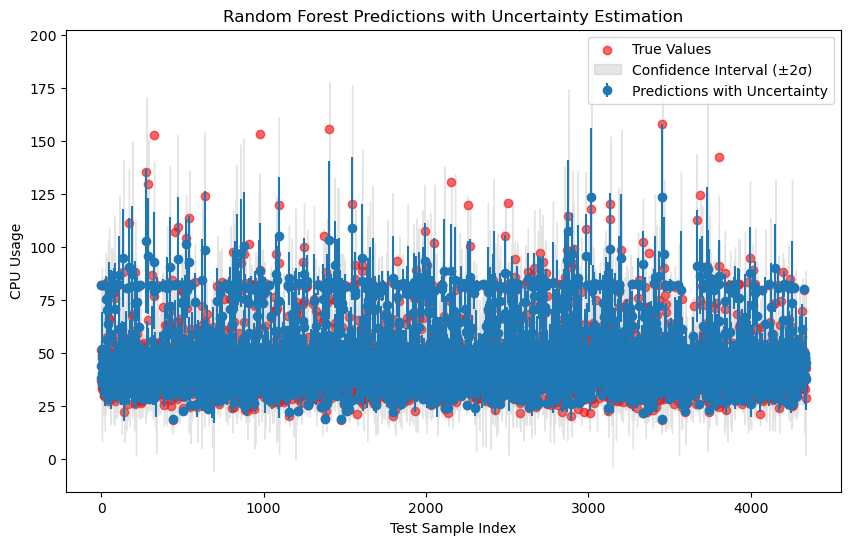

In [13]:

all_preds = np.array([tree.predict(X_test) for tree in regr.estimators_])

# Mean prediction
mean_preds = np.mean(all_preds, axis=0)

# Standard deviation = uncertainty estimate
std_preds = np.std(all_preds, axis=0)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), mean_preds, yerr=std_preds, fmt='o', label='Predictions with Uncertainty')
plt.scatter(range(len(y_test)), y_test, color='red', label='True Values', alpha=0.6)
plt.fill_between(range(len(y_test)), mean_preds - 2*std_preds, mean_preds + 2*std_preds, color='gray', alpha=0.2, label='Confidence Interval (±2σ)')
plt.xlabel('Test Sample Index')

plt.ylabel('CPU Usage')
plt.title('Random Forest Predictions with Uncertainty Estimation')
plt.legend()
plt.show()


In [10]:
joblib.dump(regr, f'mlp_models_all_rules_cpu.joblib', protocol=4)

['mlp_models_all_rules_cpu.joblib']

In [55]:
Y = fake_df.loc[:, fake_df.columns.str.contains("cpu")]
Y.loc[:, Y.columns.str.contains(rule)].sum(axis=1)

0        3.59
2        2.28
3        2.71
4        2.17
5        1.81
         ... 
49868    0.00
49869    0.00
49870    0.00
49871    0.00
49872    0.00
Length: 49171, dtype: float64

In [79]:
y_pred_fake_all

array([40.4253, 40.6976, 55.5401, ..., 57.7269, 56.0624, 57.8703])

In [80]:
Y_all

0         55.69
2         59.58
3         54.68
4         47.26
5         44.85
          ...  
49581     91.22
49618    106.63
49686     99.54
49816     78.60
49825     79.43
Length: 15794, dtype: float64

In [77]:
# predict the cpu usage of fake df
X_distribution_fake = fake_df.iloc[:,fake_df.columns.str.contains("wineventlog")]
X_distribution_fake = X_distribution_fake.fillna(0)  # Fill NaN values with 0
X_distribution_fake = X_distribution_fake.apply(lambda x: (x - dist_min) / (dist_max - dist_min), axis=0)  # Normalize each column
X_distribution_fake = X_distribution_fake.fillna(0)  # Fill NaN values with 0
X_alerts_fake = fake_df.iloc[:, fake_df.columns.str.contains("alert")]

for rule in section_logtypes:
    for logtype, eventid in section_logtypes[rule]:

        X_alerts_fake_rule = X_alerts_fake.iloc[:, X_alerts_fake.columns.str.contains(rule)]
        
        # normalize the alert values
        X_alerts_fake_rule = X_alerts_fake_rule.fillna(0)  # Fill NaN values with 0
        X_alerts_fake_rule = X_alerts_fake_rule.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)  # Normalize each column
        X_alerts_fake_rule = X_alerts_fake_rule.fillna(0)  # Fill NaN values with 0
        
        # X = X_distribution
        X_fake = pd.concat([X_distribution_fake, X_alerts_fake_rule], axis=1)
        Y = fake_df.loc[:, fake_df.columns.str.contains("cpu")]
        Y = Y.loc[:, Y.columns.str.contains(rule)].sum(axis=1)
        # Y = X_alerts.sum(axis=1)

        # normalize the cpu values
        # Y = (Y - Y.min()) / (Y.max() - Y.min())  # Normalize the target variable

        model = models.get(f"{rule}_RandomForestRegressor")
        if model:
            y_pred_fake = model.predict(X_fake)
            # clip negative values
            # y_pred_fake = np.clip(y_pred_fake, 0, None)
            # round the values
            # y_pred_fake = np.round(y_pred_fake)
            print(f"Rule: {rule}, Model: RandomForestRegressor")
            # evaluate the prediction
            print(f"R2 Score: {model.score(X_fake, Y)}")
            
X_fake_all = pd.concat([X_distribution_fake, X_alerts_fake], axis=1)
model_all = models.get(f"All_RandomForestRegressor")
if model_all:
    y_pred_fake_all = model_all.predict(X_fake_all)
    # clip negative values
    # y_pred_fake_all = np.clip(y_pred_fake_all, 0, None)
    # round the values
    # y_pred_fake_all = np.round(y_pred_fake_all)
    Y_all = fake_df.loc[:, fake_df.columns.str.contains("cpu")]
    Y_all = Y_all.sum(axis=1)
    print(f"All Model: RandomForestRegressor")
    print(f"R2 Score: {model_all.score(X_fake_all, Y_all)}")
    

Rule: Detect New Local Admin account, Model: RandomForestRegressor
R2 Score: -0.7574821451199976
Rule: Windows Event For Service Disabled, Model: RandomForestRegressor
R2 Score: -1.0868919048889332
Rule: Known Services Killed by Ransomware, Model: RandomForestRegressor
R2 Score: -0.5820954080529104
Rule: Kerberoasting spn request with RC4 encryption, Model: RandomForestRegressor
R2 Score: -0.7768580218777741
Rule: Clop Ransomware Known Service Name, Model: RandomForestRegressor
R2 Score: -0.1900981917650746
Rule: Non Chrome Process Accessing Chrome Default Dir, Model: RandomForestRegressor
R2 Score: -0.8860488005980078
Rule: ESCU Network Share Discovery Via Dir Command Rule, Model: RandomForestRegressor
R2 Score: -0.8521552019999199
Rule: Windows AD Replication Request Initiated from Unsanctioned Location, Model: RandomForestRegressor
R2 Score: -0.13602894401525156
Rule: ESCU Windows Rapid Authentication On Multiple Hosts Rule, Model: RandomForestRegressor
R2 Score: -0.1986933255041312